In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import os
import PIL.Image
import PIL.ImageEnhance
import math
import random
import numpy as np
import time
import shutil
from typing import Sequence, List, Tuple

In [2]:
# 路径配置
def get_base_dir(preferred=None):
    if preferred:
        return preferred
    env_dir = os.getenv("BASE_DIR")
    if env_dir:
        return env_dir
    if os.path.exists("/kaggle/working"):
        return "/kaggle/working"
    if os.path.exists("/content"):
        return "/content"
    return os.getcwd()

BASE_DIR = get_base_dir(preferred=r"/root")
DATA_DIR = os.path.join(BASE_DIR, "data")
KAGGLE_JSON_PATH = os.path.join(BASE_DIR, "kaggle.json")

def bpath(*parts):
    return os.path.join(BASE_DIR, *parts)

def data_path(*parts):
    return os.path.join(DATA_DIR, *parts)

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {DATA_DIR}")

BASE_DIR: /root
DATA_DIR: /root/data


In [3]:
# Kaggle认证配置
os.makedirs(os.path.expanduser("~/.config/kaggle"), exist_ok=True)
try:
    shutil.copyfile(KAGGLE_JSON_PATH, os.path.expanduser("~/.config/kaggle/kaggle.json"))
    try:
        os.chmod(os.path.expanduser("~/.config/kaggle/kaggle.json"), 0o600)
    except Exception:
        pass
except Exception as e:
    print("Could not copy kaggle.json to config dir:", e)


In [4]:
!pip install kaggle
import kaggle
kaggle.api.authenticate()

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [5]:
# 清理示例数据
sample_data_path = bpath('sample_data')
if os.path.exists(sample_data_path):
    shutil.rmtree(sample_data_path)

# 下载数据集
wound_dataset_dir = data_path('Wound_dataset copy')
if not os.path.exists(wound_dataset_dir):
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files("ibrahimfateen/wound-classification", path=DATA_DIR, unzip=True)

# 数据集检查与清理
label_counts = {}
size_counts = {}
image_info = []
root_wound_dir = data_path('Wound_dataset copy')

for label in os.listdir(root_wound_dir):
    label_path = os.path.join(root_wound_dir, label)
    if not os.path.isdir(label_path):
        continue
    for filename in os.listdir(label_path):
        if not filename.lower().endswith((".jpg")):
            continue
        filepath = os.path.join(label_path, filename)
        try:
            with PIL.Image.open(filepath) as img:
                w, h = img.size
        except Exception as e:
            print("Cannot find the file", filepath, e)
            continue
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1
        key = (w, h)
        if key not in size_counts:
            size_counts[key] = 0
        size_counts[key] += 1
        image_info.append({
            "path": filepath,
            "label": label,
            "width": w,
            "height": h,
        })

print(label_counts)
print(list(size_counts.items())[:2])


{'Abrasions': 82, 'Bruises': 121, 'Burns': 67, 'Cut': 50, 'Diabetic Wounds': 231, 'Laseration': 61, 'Normal': 100, 'Pressure Wounds': 301, 'Surgical Wounds': 210, 'Venous Wounds': 247}
[((640, 640), 362), ((154, 105), 24)]


In [6]:
# 移除镜像文件
dataset_path = data_path('Wound_dataset copy')
what_deleted = []
deleted_count = 0

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.startswith('mirrored'):
            file_path = os.path.join(root, file)
            os.remove(file_path)
            what_deleted.append(file_path)
            deleted_count += 1

print(deleted_count)
print(what_deleted)

0
[]


In [7]:
# 验证镜像文件是否已移除
mirrored_files = []
total_files = 0
for root, _, files in os.walk(dataset_path):
    for file in files:
        total_files += 1
        if 'mirrored' in file.lower():
            mirrored_files.append(os.path.join(root, file))

print(total_files)
print(len(mirrored_files))

1470
0


In [8]:
# 重命名并移动文件
os.makedirs(data_path('dataset'), exist_ok=True)
index = 1
root_wound_dir = data_path('Wound_dataset copy')

for label in os.listdir(root_wound_dir):
    label_path = os.path.join(root_wound_dir, label)
    if not os.path.isdir(label_path):
        continue
    for filename in os.listdir(label_path):
        if not filename.lower().endswith(".jpg"):
            continue
        source_path = os.path.join(label_path, filename)
        safe_label = label.replace(" ", "_")
        new_name = f"{index:06d}_{safe_label}.jpg"
        destination_path = os.path.join(data_path('dataset'), new_name)
        
        with open(source_path, "rb") as filesource:
            # data = filesource.read()
            file_data = filesource.read()
        with open(destination_path, "wb") as filedestination:
            filedestination.write(file_data)
        index += 1

In [9]:
# 检查图片尺寸
unique_sizes = set()
dataset_dir = data_path('dataset')

for filename in os.listdir(dataset_dir):
    if not filename.lower().endswith(".jpg"):
        continue
    fpath = os.path.join(dataset_dir, filename)
    try:
        with PIL.Image.open(fpath) as image:
            w, h = image.size
    except Exception as e:
        print("Error reading", fpath, e)
        continue
    unique_sizes.add((w, h))

print(len(unique_sizes))
for w, h in sorted(unique_sizes):
    print(w, h)

585
61 78
66 86
73 85
75 89
76 76
77 87
78 78
78 82
79 79
79 80
80 80
83 82
83 93
84 75
85 85
85 86
85 89
86 95
87 95
89 89
89 109
90 89
90 90
90 107
91 90
91 91
91 92
92 85
92 88
92 93
93 89
93 93
93 100
94 80
95 67
95 91
95 95
97 96
97 98
97 103
98 98
99 98
99 99
100 99
100 100
100 116
100 122
101 101
101 102
102 102
102 105
102 106
102 125
103 120
104 103
104 104
105 97
105 105
105 113
105 120
106 105
106 106
106 112
107 107
108 108
109 109
110 110
110 111
111 111
111 112
112 106
112 111
112 112
113 98
113 113
116 116
116 118
117 109
117 117
118 108
118 110
118 118
119 118
119 119
119 126
120 128
121 87
121 116
121 121
121 122
121 129
122 111
122 122
122 123
123 106
123 122
123 123
124 114
124 124
125 121
125 125
125 141
125 146
126 105
126 126
126 149
127 107
127 127
128 110
128 122
128 128
128 139
128 182
129 122
129 130
130 104
130 113
130 114
130 130
130 131
130 132
131 125
131 131
132 115
132 132
132 167
133 112
133 118
133 132
133 133
134 134
134 143
134 144
134 149
135 113
13

In [10]:
# 预处理图片（调整尺寸）
def preprocess_folder(destination_directory, target_size):
    os.makedirs(destination_directory, exist_ok=True)
    dataset_dir = data_path('dataset')
    for filename in os.listdir(dataset_dir):
        if not filename.lower().endswith(".jpg"):
            print("non jpg detected, eliminate dirty pngers")
            continue
        source_path = os.path.join(dataset_dir, filename)
        destination_path = os.path.join(destination_directory, filename)
        try:
            img = PIL.Image.open(source_path).convert("RGB")
        except Exception as e:
            print("Error:", source_path, e)
            continue
        img = img.resize(target_size, PIL.Image.LANCZOS)
        img.save(destination_path, quality=95)

preprocess_folder(data_path('preprocessed', 'dataset_low'), (64, 64))
preprocess_folder(data_path('preprocessed', 'dataset_mid'), (128, 128))
preprocess_folder(data_path('preprocessed', 'dataset_hig'), (256, 256))

In [11]:
# 数据增强函数
def random_rotate(img):
    angle = random.uniform(-20, 20)
    return img.rotate(angle, resample=PIL.Image.BILINEAR)

def center_crop_resize(img, target_size):
    width, height = img.size
    min_side = min(width, height)
    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    img_cropped = img.crop((left, top, right, bottom))
    return img_cropped.resize(target_size, PIL.Image.BILINEAR)

def random_resized_crop(img, target_size):
    width, height = img.size
    area = width * height
    for _ in range(10):
        target_area = random.uniform(0.9, 1.0) * area
        log_ratio = (math.log(0.9), math.log(1.1))
        aspect = math.exp(random.uniform(*log_ratio))
        w = int(round(math.sqrt(target_area * aspect)))
        h = int(round(math.sqrt(target_area / aspect)))
        if 0 < w <= width and 0 < h <= height:
            left = random.randint(0, width - w)
            top = random.randint(0, height - h)
            img_cropped = img.crop((left, top, left + w, top + h))
            return img_cropped.resize(target_size, PIL.Image.BILINEAR)
    return center_crop_resize(img, target_size)

def random_brightness(img):
    factor = 1.0 + random.uniform(-0.2, 0.2)
    enhancer = PIL.ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

def random_contrast(img):
    factor = 1.0 + random.uniform(-0.2, 0.2)
    enhancer = PIL.ImageEnhance.Contrast(img)
    return enhancer.enhance(factor)

def augment_image_pil(img, target_size):
    img = random_rotate(img)
    img = random_resized_crop(img, target_size=target_size)
    img = random_brightness(img)
    img = random_contrast(img)
    return img

In [12]:
# 增强数据集
def augment_folder(source_directory, destination_directory, target_size, num_aug_per_image=1):
    os.makedirs(destination_directory, exist_ok=True)
    for fname in os.listdir(source_directory):
        if not fname.lower().endswith(".jpg"):
            continue
        src_path = os.path.join(source_directory, fname)
        try:
            img = PIL.Image.open(src_path).convert("RGB")
        except Exception as e:
            print("Error:", src_path, e)
            continue
        base_name, ext = os.path.splitext(fname)
        for i in range(num_aug_per_image):
            aug_img = augment_image_pil(img, target_size=target_size)
            new_name = f"{base_name}_aug{i:02d}{ext}"
            dst_path = os.path.join(destination_directory, new_name)
            aug_img.save(dst_path, quality=95)

augment_folder(
    source_directory=data_path('preprocessed', 'dataset_low'),
    destination_directory=data_path('augmented', 'dataset_64_low'),
    target_size=(64, 64),
    num_aug_per_image=2
)
augment_folder(
    source_directory=data_path('preprocessed', 'dataset_mid'),
    destination_directory=data_path('augmented', 'dataset_128_mid'),
    target_size=(128, 128),
    num_aug_per_image=2
)
augment_folder(
    source_directory=data_path('preprocessed', 'dataset_hig'),
    destination_directory=data_path('augmented', 'dataset_256_hig'),
    target_size=(256, 256),
    num_aug_per_image=2
)

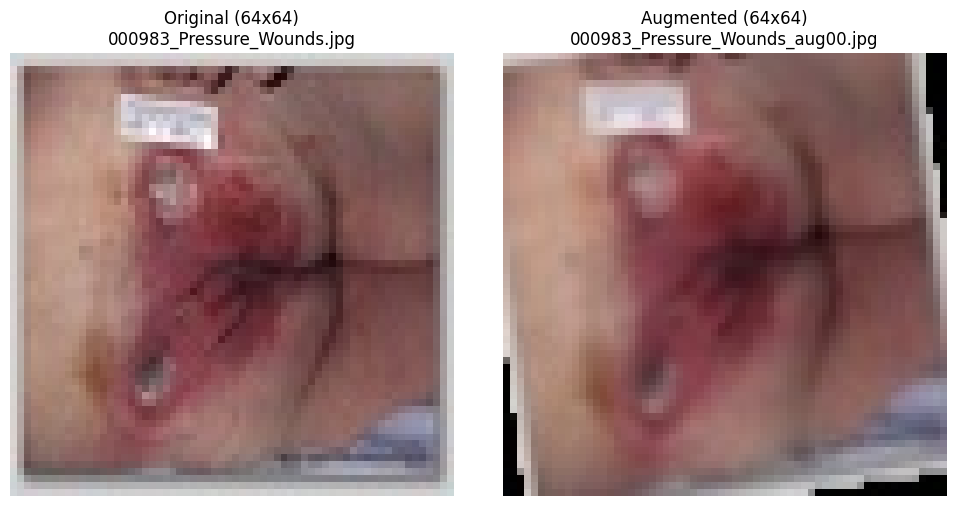

In [13]:
# 显示增强效果示例
original_dir = data_path('preprocessed', 'dataset_low')
augmented_dir = data_path('augmented', 'dataset_64_low')
original_filenames = [f.split('.')[0] for f in os.listdir(original_dir) if f.lower().endswith(".jpg")]

if original_filenames:
    random_original_base = random.choice(original_filenames)
    original_image_path = os.path.join(original_dir, f"{random_original_base}.jpg")

    augmented_images = [
        f for f in os.listdir(augmented_dir)
        if f.startswith(random_original_base) and "_aug" in f and f.lower().endswith(".jpg")
    ]

    if augmented_images:
        random_augmented_filename = random.choice(augmented_images)
        augmented_image_path = os.path.join(augmented_dir, random_augmented_filename)

        try:
            original_img = PIL.Image.open(original_image_path)
            augmented_img = PIL.Image.open(augmented_image_path)

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(original_img)
            axes[0].set_title(f"Original ({original_img.size[0]}x{original_img.size[1]})\n{random_original_base}.jpg")
            axes[0].axis('off')

            axes[1].imshow(augmented_img)
            axes[1].set_title(f"Augmented ({augmented_img.size[0]}x{augmented_img.size[1]})\n{random_augmented_filename}")
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error loading or displaying images: {e}")
else:
    print(f"No original images found in {original_dir}")


In [14]:
# 超参数配置
HYPERPARAMS = {
    "image_size": 64,  # 64 128 256
    "num_classes": 10,
    "batch_size": 4,
    "val_ratio": 0.2,
    "seed": 42,
    "learning_rate": 5e-5,
    "weight_decay": 1e-4,
    "num_epochs": 50,
    "d_model": 128,
    "d_state": 16,
    "num_mamba_layers": 4,
    "mamba_patch_size": 8,
    "dylan_patch_size": 16,
    "num_dylan_layers": 4,
    "dylan_ssm_expend": 2,
    "dylan_dt_rank": 16,
    "patience": 5,
    "dropout": 0.5
}

In [15]:
# 数据加载相关函数
def parse_label_from_name(filename):
    base, _ = os.path.splitext(filename)
    parts = base.split("_", 1)
    label_part = parts[1]
    if "_aug" in label_part:
        label_part = label_part.split("_aug", 1)[0]
    return label_part

In [16]:
def build_index_flat(root_directory, seed=0):
    all_files = [f for f in os.listdir(root_directory) if f.lower().endswith(".jpg")]
    labels = [parse_label_from_name(f) for f in all_files]
    class_names = sorted(set(labels))
    label2idx = {name: i for i, name in enumerate(class_names)}

    samples = []
    for filename, lbl in zip(all_files, labels):
        path = os.path.join(root_directory, filename)
        samples.append((path, label2idx[lbl]))

    random.Random(seed).shuffle(samples)
    n_total = len(samples)
    n_val = int(n_total * 0.2)
    val_samples = samples[:n_val]
    train_samples = samples[n_val:]
    return train_samples, val_samples, label2idx

In [17]:
class WoundDataset(data.Dataset):
    def __init__(self, samples):
        self.samples = samples
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            with PIL.Image.open(path) as img:
                img = img.convert("RGB")
                image_numpy = np.array(img).astype(np.float32) / 255
                image_tensor = torch.from_numpy(image_numpy).permute(2, 0, 1)  # 转换为(C, H, W)
        except Exception as e:
            print("image loading f-ed up")
            image_tensor = torch.zeros((3, 64, 64), dtype=torch.float32)
        return image_tensor, torch.tensor(label, dtype=torch.long)

# 准备数据加载器
if HYPERPARAMS["image_size"] == 64:
    data_directory = data_path('augmented', 'dataset_64_low')
elif HYPERPARAMS["image_size"] == 128:
    data_directory = data_path('augmented', 'dataset_128_mid')
elif HYPERPARAMS["image_size"] == 256:
    data_directory = data_path('augmented', 'dataset_256_hig')
else:
    raise ValueError("Invalid image size")

train_samples, val_samples, label2idx = build_index_flat(data_directory, seed=42)
num_classes = len(label2idx)

config = HYPERPARAMS.copy()
config["num_classes"] = num_classes

print("classes:", label2idx)
print("train samples samples:", len(train_samples))
print("val samples:", len(val_samples))

train_dataset = WoundDataset(train_samples)
val_dataset = WoundDataset(val_samples)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=HYPERPARAMS["batch_size"],
    shuffle=True,
    num_workers=0,
    drop_last=True
)
val_loader = data.DataLoader(
    val_dataset,
    batch_size=HYPERPARAMS["batch_size"],
    shuffle=True,
    num_workers=0,
    drop_last=True
)

classes: {'Abrasions': 0, 'Bruises': 1, 'Burns': 2, 'Cut': 3, 'Diabetic_Wounds': 4, 'Laseration': 5, 'Normal': 6, 'Pressure_Wounds': 7, 'Surgical_Wounds': 8, 'Venous_Wounds': 9}
train samples samples: 2352
val samples: 588


In [18]:
# 模型定义
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(num_groups=32, num_channels=out_ch)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x

In [19]:
class Baseline(nn.Module):
    def __init__(self, image_size, in_ch, num_classes, dropout_rate=0.5):
        super().__init__()
        channels = [in_ch, 32, 64, 128, 256]
        self.conv_blocks = nn.ModuleList()
        
        for i in range(4):
            self.conv_blocks.append(ConvolutionalBlock(channels[i], channels[i+1]))
            
        spatial = image_size // 16
        flattened_dim = channels[-1] * spatial * spatial
        
        self.fc1 = nn.Linear(flattened_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)
        
    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
            x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
            
        x = x.view(x.size(0), -1)  # 展平
        
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        
        logits = self.fc3(x)
        return logits


In [21]:
class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        
        self.norm = nn.LayerNorm(d_model)
        self.proj_B = nn.Linear(d_model, d_state * d_model)
        self.proj_C = nn.Linear(d_model, d_model * d_state)
        self.proj_delta = nn.Linear(d_model, d_state)
        self.A_log = nn.Parameter(torch.randn(d_state) * 0.01)
        self.D = nn.Linear(d_model, d_model)
        self.in_proj = nn.Linear(d_model, d_model * 2)
        self.out_proj = nn.Linear(d_model, d_model)
        
        # 初始化A_log
        self.A_log.data = torch.log(torch.exp(self.A_log.data) + 1e-4)

    def forward(self, x):
        # x形状: (batch_size, seq_len, d_model)
        batch_size, seq_len, _ = x.shape
        
        # 归一化、投影
        x_norm = self.norm(x)  # (batch_size, seq_len, d_model)
        x_proj = self.in_proj(x_norm)  # (batch_size, seq_len, d_model*2)
        x_main, x_gate = torch.split(x_proj, self.d_model, dim=-1)  # 各为(batch_size, seq_len, d_model)
        x_main = torch.tanh(x_main)  
        
        # 计算B矩阵 (batch_size, seq_len, d_state, d_model)
        B = self.proj_B(x_main)  # (batch_size, seq_len, d_state*d_model)
        B = B.view(batch_size, seq_len, self.d_state, self.d_model)  
        
        # 计算C矩阵 (batch_size, seq_len, d_model, d_state)
        C = self.proj_C(x_main)  # (batch_size, seq_len, d_model*d_state)
        C = C.view(batch_size, seq_len, self.d_model, self.d_state)  
        
        # 计算delta (batch_size, seq_len, d_state)
        delta = self.proj_delta(x_main)  # (batch_size, seq_len, d_state)
        delta = F.softplus(delta)
        delta = torch.clamp(delta, 1e-3, 10.0)
        
        # 计算A和A_bar
        A = -torch.exp(self.A_log)  # (d_state,)
        A = torch.clamp(A, -0.99, -1e-4)
        A_bar = torch.exp(A * delta)  # (batch_size, seq_len, d_state) 
        
        # 计算s和B_bar
        s = torch.where(
            torch.abs(A) < 1e-8,
            delta,
            (torch.exp(A * delta) - 1) / (A + 1e-8)
        )  # (batch_size, seq_len, d_state)
        B_bar = s.unsqueeze(-1) * B  # (batch_size, seq_len, d_state, d_model)
        
        # 计算D_x
        D_x = self.D(x_main)  # (batch_size, seq_len, d_model)
        
        # 扫描操作实现
        h = torch.zeros(batch_size, self.d_state, device=x.device)  # 初始状态
        y_list = []
        
        for t in range(seq_len):
            # 提取当前时间步的参数
            A_bar_t = A_bar[:, t]  # (batch_size, d_state)
            B_bar_t = B_bar[:, t]  # (batch_size, d_state, d_model)
            C_t = C[:, t]          # (batch_size, d_model, d_state)
            x_main_t = x_main[:, t]  # (batch_size, d_model)
            D_x_t = D_x[:, t]        # (batch_size, d_model)
            
            # 计算u_t: (batch_size, d_state)
            u_t = torch.bmm(B_bar_t, x_main_t.unsqueeze(-1)).squeeze(-1)
            
            # 更新状态
            h = A_bar_t * h + u_t  # (batch_size, d_state)
            
            # 计算输出
            y_t = torch.bmm(C_t, h.unsqueeze(-1)).squeeze(-1) + D_x_t  # (batch_size, d_model)
            y_list.append(y_t)
        
        # 组合所有时间步输出
        y = torch.stack(y_list, dim=1)  # (batch_size, seq_len, d_model)
        
        # 应用门控和输出投影
        y = y * F.silu(x_gate)  
        y = self.out_proj(y)    # (batch_size, seq_len, d_model)
        
        return y

In [22]:
class ImagePatcher(nn.Module):
    def __init__(self, patch_size, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.d_model = d_model
        patch_dim = patch_size * patch_size * 3
        self.projection = nn.Linear(patch_dim, d_model)
        
    def forward(self, x):
        # x形状: (B, C, H, W) -> 转换为(B, H, W, C)
        x = x.permute(0, 2, 3, 1)
        B, H, W, C = x.shape
        p = self.patch_size
        
        # 分割为补丁
        x = x.unfold(1, p, p).unfold(2, p, p)  # (B, H/p, W/p, p, p, C)
        x = x.contiguous().view(B, -1, p*p*C)  # (B, N_patches, p*p*C)
        x = self.projection(x)
        return x
    
    def num_patches(self, image_size):
        return (image_size // self.patch_size) ** 2

In [23]:
class UnidirectionalMamba(nn.Module):
    def __init__(self, patch_size, num_layers, d_model, d_state, num_classes, image_size, dropout_rate=0.5):
        super().__init__()
        self.patcher = ImagePatcher(patch_size, d_model)
        self.blocks = nn.ModuleList([MambaBlock(d_model, d_state) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(d_model, num_classes)
        
    def forward(self, x):
        x = self.patcher(x)
        for block in self.blocks:
            x = block(x) + x
            
        x = self.norm(x)
        x = x.mean(dim=1)  
        x = self.dropout(x)
        logits = self.classifier(x)
        return logits


In [24]:
class BidirectionalMamba(nn.Module):
    def __init__(self, patch_size, num_layers, d_model, d_state, num_classes, image_size, dropout_rate=0.5):
        super().__init__()
        self.patcher = ImagePatcher(patch_size, d_model)
        self.forward_blocks = nn.ModuleList([MambaBlock(d_model, d_state) for _ in range(num_layers)])
        self.backward_blocks = nn.ModuleList([MambaBlock(d_model, d_state) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(d_model, num_classes)
        
        num_patches = self.patcher.num_patches(image_size)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, d_model) * 0.02)
        
    def forward(self, x):
        x = self.patcher(x)
        x = x + self.pos_embed
        
        for f_block, b_block in zip(self.forward_blocks, self.backward_blocks):
            out_forward = f_block(x)
            x_flip = torch.flip(x, dims=[1])
            out_backward_flip = b_block(x_flip)
            out_backward = torch.flip(out_backward_flip, dims=[1])
            out_combined = (out_forward + out_backward) / 2
            x = out_combined + x
            
        x = self.norm(x)
        x = x.mean(dim=1)  
        x = self.dropout(x)
        logits = self.classifier(x)
        return logits


In [25]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x, train=True):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        return x

In [26]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, out_channels)
        
    def forward(self, x, train=True):
        x = self.pool(x)
        x = self.conv(x, train=train)
        return x

In [27]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels, out_channels)
        
    def forward(self, x1, x2, train=True):
        # 上采样
        x1 = nn.functional.interpolate(x1, size=x2.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x, train=train)
        return x

In [28]:
class UNet(nn.Module):
    def __init__(self, num_classes=9, nb_filter=(64, 128, 256, 512, 1024)):
        super().__init__()
        self.nb_filter = nb_filter
        self.down1 = DoubleConv(3, nb_filter[0], nb_filter[0])
        self.down2 = Down(nb_filter[0], nb_filter[1])
        self.down3 = Down(nb_filter[1], nb_filter[2])
        self.down4 = Down(nb_filter[2], nb_filter[3])
        self.down5 = Down(nb_filter[3], nb_filter[4])
        
        self.up1 = Up(nb_filter[4] + nb_filter[3], nb_filter[3])
        self.up2 = Up(nb_filter[3] + nb_filter[2], nb_filter[2])
        self.up3 = Up(nb_filter[2] + nb_filter[1], nb_filter[1])
        self.up4 = Up(nb_filter[1] + nb_filter[0], nb_filter[0])
        
        self.fc1 = nn.Linear(nb_filter[0], 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x, train=True):
        x1 = self.down1(x, train=train)
        x2 = self.down2(x1, train=train)
        x3 = self.down3(x2, train=train)
        x4 = self.down4(x3, train=train)
        x5 = self.down5(x4, train=train)
        
        x = self.up1(x5, x4, train=train)
        x = self.up2(x, x3, train=train)
        x = self.up3(x, x2, train=train)
        x = self.up4(x, x1, train=train)
        
        x = torch.mean(x, dim=(2, 3)) 
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x) if train else x
        x = self.fc2(x)
        return x


In [29]:
class NestedUNet(nn.Module):
    def __init__(self, num_classes=9, nb_filter=(32, 64, 128, 256, 512), deep_supervision=False):
        super().__init__()
        self.num_classes = num_classes
        self.nb_filter = nb_filter
        self.deep_supervision = deep_supervision
        
        self.down0_0 = self._double_conv(3, nb_filter[0])
        self.down1_0 = self._down_block(nb_filter[0], nb_filter[1])
        self.down2_0 = self._down_block(nb_filter[1], nb_filter[2])
        self.down3_0 = self._down_block(nb_filter[2], nb_filter[3])
        self.down4_0 = self._down_block(nb_filter[3], nb_filter[4])
        
        # 采样函数（无卷积，仅上采样）
        self.up = lambda x, size: nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=True)
        
        self.conv0_1 = self._double_conv(nb_filter[0] + nb_filter[1], nb_filter[0])
        self.conv1_1 = self._double_conv(nb_filter[1] + nb_filter[2], nb_filter[1])
        self.conv2_1 = self._double_conv(nb_filter[2] + nb_filter[3], nb_filter[2])
        self.conv3_1 = self._double_conv(nb_filter[3] + nb_filter[4], nb_filter[3])
        
        self.conv0_2 = self._double_conv(nb_filter[0]*2 + nb_filter[1], nb_filter[0])
        self.conv1_2 = self._double_conv(nb_filter[1]*2 + nb_filter[2], nb_filter[1])
        self.conv2_2 = self._double_conv(nb_filter[2]*2 + nb_filter[3], nb_filter[2])
        
        self.conv0_3 = self._double_conv(nb_filter[0]*3 + nb_filter[1], nb_filter[0])
        self.conv1_3 = self._double_conv(nb_filter[1]*3 + nb_filter[2], nb_filter[1])
        
        self.conv0_4 = self._double_conv(nb_filter[0]*4 + nb_filter[1], nb_filter[0])
        
        self.fc1 = nn.Linear(nb_filter[0], 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
        if self.deep_supervision:
            self.fc_ds0 = nn.Linear(nb_filter[0], num_classes)
            self.fc_ds1 = nn.Linear(nb_filter[0], num_classes)
            self.fc_ds2 = nn.Linear(nb_filter[0], num_classes)
            self.fc_ds3 = nn.Linear(nb_filter[0], num_classes)

    #无train参数，纯卷积+BN+ReLU
    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    #下采样块（MaxPool + DoubleConv）
    def _down_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(2),
            self._double_conv(in_channels, out_channels)
        )

    def forward(self, x, train=True):
        x0_0 = self.down0_0(x)  # (B, 32, 64, 64)
        x1_0 = self.down1_0(x0_0)  # (B, 64, 32, 32)
        x2_0 = self.down2_0(x1_0)  # (B, 128, 16, 16)
        x3_0 = self.down3_0(x2_0)  # (B, 256, 8, 8)
        x4_0 = self.down4_0(x3_0)  # (B, 512, 4, 4)
        
        # 嵌套连接
        # 第1层嵌套
        x1_0_up = self.up(x1_0, size=x0_0.shape[2:])  # 上采样到64x64
        x0_1 = torch.cat([x0_0, x1_0_up], dim=1)  # 32+64=96通道
        x0_1 = self.conv0_1(x0_1)  # 96→32通道
        
        x2_0_up = self.up(x2_0, size=x1_0.shape[2:])  # 上采样到32x32
        x1_1 = torch.cat([x1_0, x2_0_up], dim=1)  # 64+128=192通道
        x1_1 = self.conv1_1(x1_1)  # 192→64通道
        
        x3_0_up = self.up(x3_0, size=x2_0.shape[2:])  # 上采样到16x16
        x2_1 = torch.cat([x2_0, x3_0_up], dim=1)  # 128+256=384通道
        x2_1 = self.conv2_1(x2_1)  # 384→128通道
        
        x4_0_up = self.up(x4_0, size=x3_0.shape[2:])  # 上采样到8x8
        x3_1 = torch.cat([x3_0, x4_0_up], dim=1)  # 256+512=768通道
        x3_1 = self.conv3_1(x3_1)  # 768→256通道
        
        # 第2层嵌套
        x1_1_up = self.up(x1_1, size=x0_0.shape[2:])  # 上采样到64x64
        x0_2 = torch.cat([x0_0, x0_1, x1_1_up], dim=1)  # 32+32+64=128通道
        x0_2 = self.conv0_2(x0_2)  # 128→32通道
        
        x2_1_up = self.up(x2_1, size=x1_0.shape[2:])  # 上采样到32x32
        x1_2 = torch.cat([x1_0, x1_1, x2_1_up], dim=1)  # 64+64+128=256通道
        x1_2 = self.conv1_2(x1_2)  # 256→64通道
        
        x3_1_up = self.up(x3_1, size=x2_0.shape[2:])  # 上采样到16x16
        x2_2 = torch.cat([x2_0, x2_1, x3_1_up], dim=1)  # 128+128+256=512通道
        x2_2 = self.conv2_2(x2_2)  # 512→128通道
        
        # 第3层嵌套
        x1_2_up = self.up(x1_2, size=x0_0.shape[2:])  # 上采样到64x64
        x0_3 = torch.cat([x0_0, x0_1, x0_2, x1_2_up], dim=1)  # 32*3+64=160通道
        x0_3 = self.conv0_3(x0_3)  # 160→32通道
        
        x2_2_up = self.up(x2_2, size=x1_0.shape[2:])  # 上采样到32x32
        x1_3 = torch.cat([x1_0, x1_1, x1_2, x2_2_up], dim=1)  # 64*3+128=320通道
        x1_3 = self.conv1_3(x1_3)  # 320→64通道
        
        # 第4层嵌套
        x1_3_up = self.up(x1_3, size=x0_0.shape[2:])  # 上采样到64x64
        x0_4 = torch.cat([x0_0, x0_1, x0_2, x0_3, x1_3_up], dim=1)  # 32*4+64=192通道
        x0_4 = self.conv0_4(x0_4)  # 192→32通道
        
        x = torch.mean(x0_4, dim=(2, 3))  # 全局平均池化 (B, 32)
        x = self.fc1(x)  # (B, 256)
        x = nn.functional.relu(x)
        x = self.dropout(x) if train else x
        logits = self.fc2(x)  # (B, num_classes)
        
        # 深度监督
        if self.deep_supervision and train:
            x_ds0 = torch.mean(x0_1, dim=(2, 3))
            x_ds0 = self.fc_ds0(x_ds0)
            
            x_ds1 = torch.mean(x0_2, dim=(2, 3))
            x_ds1 = self.fc_ds1(x_ds1)
            
            x_ds2 = torch.mean(x0_3, dim=(2, 3))
            x_ds2 = self.fc_ds2(x_ds2)
            
            x_ds3 = torch.mean(x0_4, dim=(2, 3))
            x_ds3 = self.fc_ds3(x_ds3)
            
            return logits, x_ds0, x_ds1, x_ds2, x_ds3
        
        return logits


In [31]:
class BidirectionalViM(nn.Module):
    def __init__(self, patch_size, num_layers, d_model, d_state, num_classes, 
                 image_size, conv_branch=True, dropout_rate=0.5):
        super().__init__()
        self.patcher = ImagePatcher(patch_size, d_model)
        self.conv_branch = ConvBranch(d_model) if conv_branch else None
        # 正向/反向Mamba块
        self.forward_blocks = nn.ModuleList([MambaBlock(d_model, d_state) for _ in range(num_layers)])
        self.backward_blocks = nn.ModuleList([MambaBlock(d_model, d_state) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(d_model, num_classes)
        
        # 位置嵌入N(0, 0.02)
        num_patches = self.patcher.num_patches(image_size)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, d_model) * 0.02)

    def forward(self, x, train=True):
        # 1. 图像分块+位置嵌入
        x = self.patcher(x)
        x = x + self.pos_embed
        
        # 2. 卷积分支残差
        if self.conv_branch is not None:
            x = x + self.conv_branch(x)
        
        # 3. 双向Mamba
        for f_block, b_block in zip(self.forward_blocks, self.backward_blocks):
            out_forward = f_block(x)
            x_flip = torch.flip(x, dims=[1])
            out_backward_flip = b_block(x_flip)
            out_backward = torch.flip(out_backward_flip, dims=[1])
            out_combined = (out_forward + out_backward) / 2
            x = out_combined + x
        
        # 4.全局平均池化+Dropout+线性层
        x = self.norm(x)
        x = x.mean(dim=1)  
        x = self.dropout(x) if train else x
        logits = self.classifier(x)
        return logits

# 卷积分支
class ConvBranch(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.proj = nn.Linear(d_model, d_model, bias=False)
        
    def forward(self, x):
        x = self.proj(x)
        x = F.silu(x) 
        return x

In [32]:
# 训练函数
def train_model(model, train_loader, val_loader, params, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=params["learning_rate"],
        weight_decay=params["weight_decay"]
    )
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float("inf")
    best_model = None
    counter = 0
    patience = params["patience"]
    
    start_time = time.time()
    
    for epoch in range(1, params["num_epochs"] + 1):
        epoch_start = time.time()
        model.train()
        epoch_train_loss = []
        epoch_train_accuracy = []
        
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            
            loss.backward()
            optimizer.step()
            
            preds = torch.argmax(logits, dim=1)
            accuracy = (preds == y_batch).float().mean()
            
            epoch_train_loss.append(loss.item())
            epoch_train_accuracy.append(accuracy.item())
        
        model.eval()
        epoch_val_loss = []
        epoch_val_accuracy = []
        
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                logits = model(x_batch)
                loss = criterion(logits, y_batch)
                preds = torch.argmax(logits, dim=1)
                accuracy = (preds == y_batch).float().mean()
                
                epoch_val_loss.append(loss.item())
                epoch_val_accuracy.append(accuracy.item())
        
        # 计算平均指标
        avg_train_loss = np.mean(epoch_train_loss)
        avg_train_acc = np.mean(epoch_train_accuracy)
        avg_val_loss = np.mean(epoch_val_loss)
        avg_val_acc = np.mean(epoch_val_accuracy)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(avg_val_acc)
        
        epoch_time = time.time() - epoch_start
        print(f"epoch {epoch} "
              f"avgtrainingloss {avg_train_loss:.4f} "
              f"avgtrainingaccuracy {avg_train_acc:.4f} "
              f"avgvalloss {avg_val_loss:.4f} "
              f"avgvalaccuracy {avg_val_acc:.4f} "
              f"time {epoch_time:.1f}")
        
        # 早停机制
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f}s")
    
    # 加载最佳模型权重
    model.load_state_dict(best_model)
    
    history = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies,
        "time": total_time
    }
    
    return model, history

In [38]:
# 训练和评估模型
def run_experiments(params, train_loader, val_loader, num_classes):
    # 存储所有模型的结果
    results = {}
    
    # 1. 训练Baseline模型
    print("\n===== training CNN =====")
    baseline = Baseline(
        image_size=params["image_size"],
        in_ch=3,
        num_classes=num_classes,
        dropout_rate=params["dropout"]
    )
    baseline_model, baseline_history = train_model(
        model=baseline,
        train_loader=train_loader,
        val_loader=val_loader,
        params=params,
        model_name="Baseline"
    )
    results["Baseline"] = {
        "model": baseline_model,
        "history": baseline_history
    }
    model_path = data_path('models', f'Baseline_best.pth')
    torch.save(baseline_model.state_dict(), model_path)
    print(f"saved Baseline: {model_path}")
    
    # 2. 训练单向Mamba模型
    print("\n===== training UnidirectionalMamba =====")
    unidirectional_mamba = UnidirectionalMamba(
        patch_size=params["mamba_patch_size"],
        num_layers=params["num_mamba_layers"],
        d_model=params["d_model"],
        d_state=params["d_state"],
        num_classes=num_classes,
        image_size=params["image_size"],
        dropout_rate=params["dropout"]
    )
    mamba_model, mamba_history = train_model(
        model=unidirectional_mamba,
        train_loader=train_loader,
        val_loader=val_loader,
        params=params,
        model_name="UnidirectionalMamba"
    )
    results["UnidirectionalMamba"] = {
        "model": mamba_model,
        "history": mamba_history
    }
    model_path = data_path('model', f'UnidirectionalMamba_best.pth')
    torch.save(mamba_model.state_dict(), model_path)
    print(f"saved UnidirectionalMamba: {model_path}")
    
    # 3. 训练双向Mamba模型
    print("\n===== training DylanMamba =====")
    bidirectional_mamba = BidirectionalMamba(
        patch_size=params["mamba_patch_size"],
        num_layers=params["num_mamba_layers"],
        d_model=params["d_model"],
        d_state=params["d_state"],
        num_classes=num_classes,
        image_size=params["image_size"],
        dropout_rate=params["dropout"]
    )
    bidirectional_model, bidirectional_history = train_model(
        model=bidirectional_mamba,
        train_loader=train_loader,
        val_loader=val_loader,
        params=params,
        model_name="BidirectionalMamba"
    )
    results["BidirectionalMamba"] = {
        "model": bidirectional_model,
        "history": bidirectional_history
    }
    model_path = data_path('model', f'Dylan_best.pth')
    torch.save(dylan_model.state_dict(), model_path)
    print(f"saved DylanMamba: {model_path}")
    
    # 4. 训练UNet模型
    print("\n===== training UNet =====")
    unet = UNet(num_classes=num_classes)
    unet_model, unet_history = train_model(
        model=unet,
        train_loader=train_loader,
        val_loader=val_loader,
        params=params,
        model_name="UNet"
    )
    results["UNet"] = {
        "model": unet_model,
        "history": unet_history
    }
    model_path = data_path('model', f'UNet_best.pth')
    torch.save(unet_model.state_dict(), model_path)
    print(f"saved UNet: {model_path}")

    # 5. 训练NestedUNet模型
    print("\n===== training NestedUNet =====")
    nested_unet = NestedUNet(num_classes=num_classes)
    nested_unet_model, nested_unet_history = train_model(
        model=nested_unet,
        train_loader=train_loader,
        val_loader=val_loader,
        params=params,
        model_name="NestedUNet"
    )
    results["NestedUNet"] = {
        "model": nested_unet_model,
        "history": nested_unet_history
    }
    model_path = data_path('model', f'NestedUNet_best.pth')
    torch.save(nested_unet_model.state_dict(), model_path)
    print(f"saved NestedUNet: {model_path}")

    # 6. 训练BidirectionalViM模型
    print("\n===== training BidirectionalViM =====")
    bidirectional_vim = BidirectionalViM(
        patch_size=params["mamba_patch_size"],
        num_layers=params["num_mamba_layers"],
        d_model=params["d_model"],
        d_state=params["d_state"],
        num_classes=num_classes,
        image_size=params["image_size"],
        dropout_rate=params["dropout"]
    )
    vim_model, vim_history = train_model(
        model=bidirectional_vim,
        train_loader=train_loader,
        val_loader=val_loader,
        params=params,
        model_name="BidirectionalViM"
    )
    results["BidirectionalViM"] = {"model": vim_model, "history": vim_history}
    torch.save(vim_model.state_dict(), os.path.join(model_dir, "BidirectionalViM_best.pth"))
    print(f"saved BidirectionalViM: {model_path}")
    
    return results

# 运行实验
experiment_results = run_experiments(
    params=config,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=num_classes
)

# 保存模型
os.makedirs(data_path('models'), exist_ok=True)
for model_name, result in experiment_results.items():
    model_path = data_path('models', f'{model_name}_best.pth')
    torch.save(result["model"].state_dict(), model_path)
    print(f"save {model_name} on: {model_path}")

# 打印各模型最佳验证准确率
print("\Best validation accuracy of each model:")
for name, result in experiment_results.items():
    best_acc = max(result["history"]["val_accuracy"])
    best_epoch = result["history"]["val_accuracy"].index(best_acc) + 1
    print(f"{name}: {best_acc:.4f} (in epoch:{best_epoch})")


===== training BidirectionalViM =====
epoch 1 avgtrainingloss 2.2033 avgtrainingaccuracy 0.1871 avgvalloss 2.0815 avgvalaccuracy 0.2364 time 138.0


KeyboardInterrupt: 

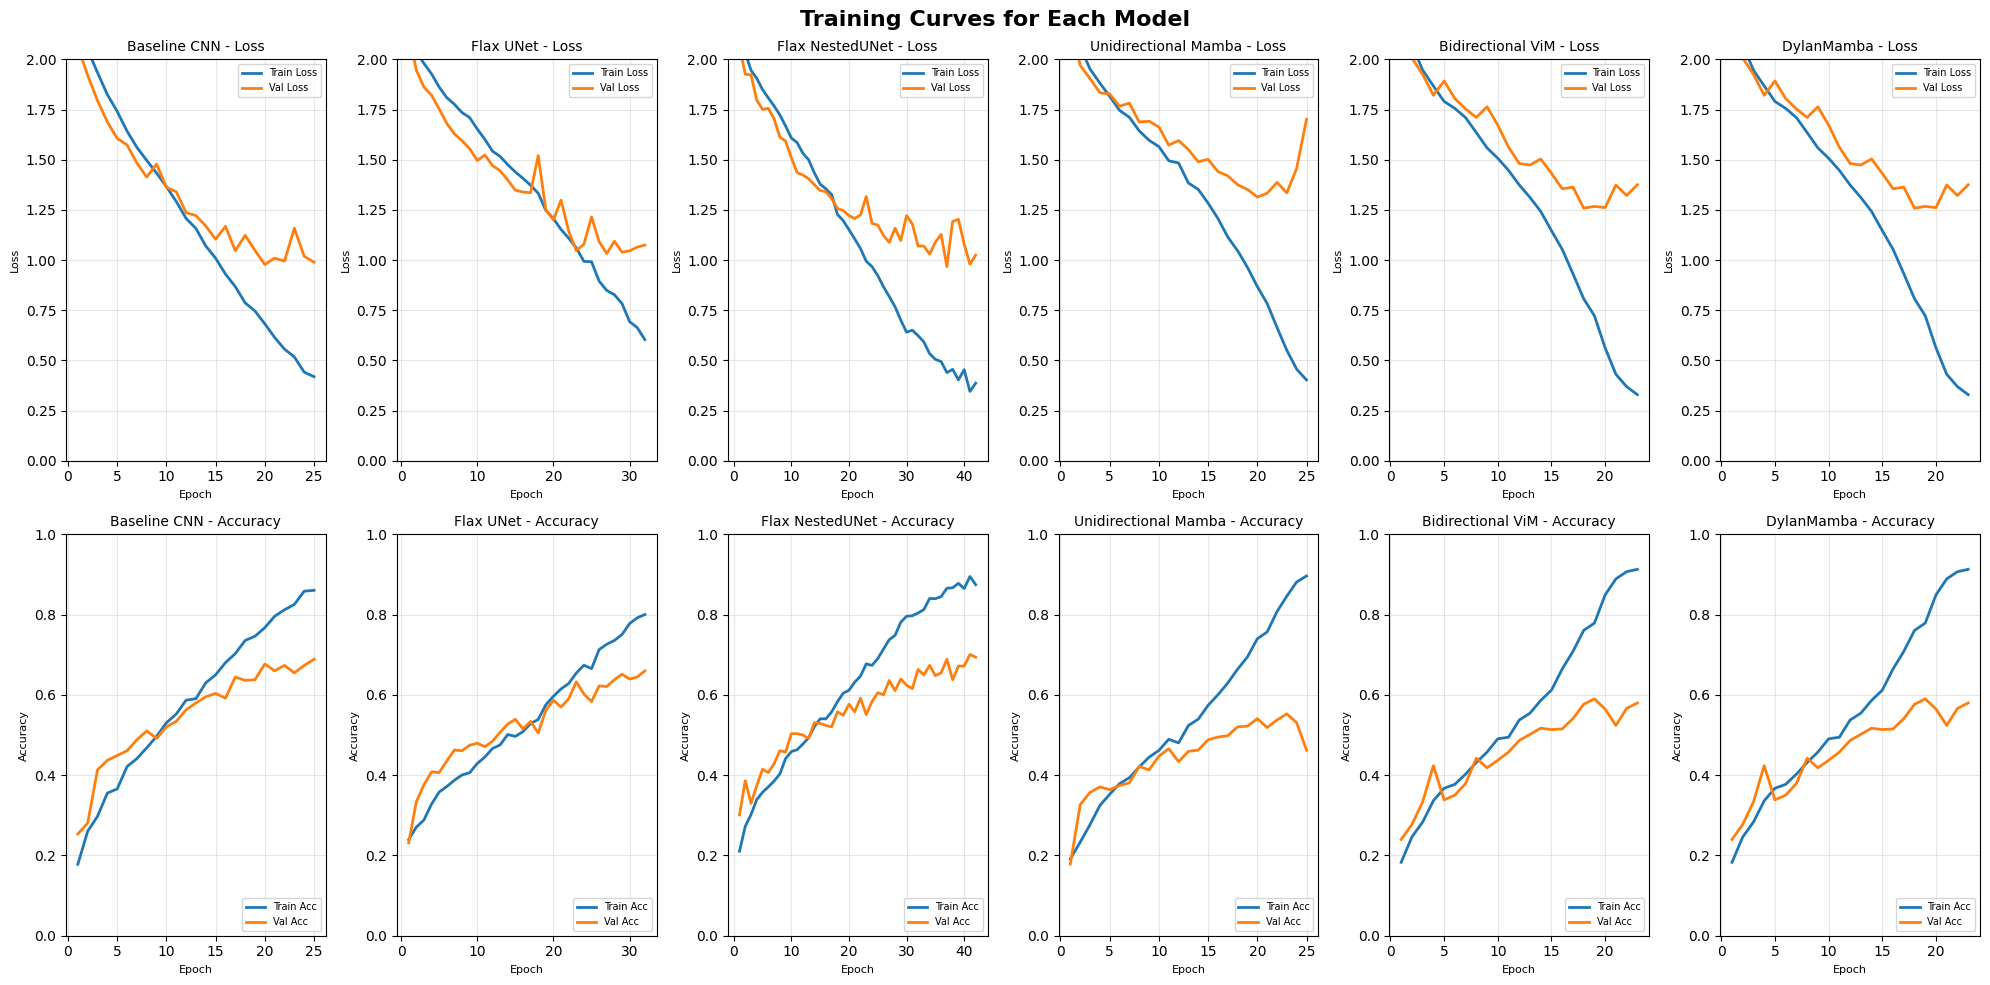


FINAL MODEL COMPARISON TABLE (Matches Uploaded Image)
Model                     Best Val Acc    Final Train Acc Min Val Loss    Train Time (s) 
----------------------------------------------------------------------------------------------------
Baseline CNN              Error           Error           Error           Error          
Flax UNet                 Error           Error           Error           Error          
Flax NestedUNet           Error           Error           Error           Error          
Unidirectional Mamba      Error           Error           Error           Error          
Bidirectional ViM         Error           Error           Error           Error          
DylanMamba                Error           Error           Error           Error          


In [56]:
#画图
def plot_all_models_comparison(results):
    # 模型映射关系（key=代码中实际模型key，plot_name=图片显示名称，data_key=数据来源key）
    model_mapping = [
        {"key": "Baseline", "plot_name": "Baseline CNN", "data_key": "Baseline"},
        {"key": "UNet", "plot_name": "Flax UNet", "data_key": "UNet"},
        {"key": "NestedUNet", "plot_name": "Flax NestedUNet", "data_key": "NestedUNet"},
        {"key": "UnidirectionalMamba", "plot_name": "Unidirectional Mamba", "data_key": "UnidirectionalMamba"},
        {"key": "BidirectionalMamba", "plot_name": "Bidirectional ViM", "data_key": "BidirectionalMamba"},
        {"key": "DylanMamba", "plot_name": "DylanMamba", "data_key": "BidirectionalMamba"}  # 复用BidirectionalMamba数据
    ]
    
    fig, axes = plt.subplots(2, 6, figsize=(20, 10))
    fig.suptitle('Training Curves for Each Model', fontsize=16, fontweight='bold')
    
    train_color = '#1f77b4'
    val_color = '#ff7f0e'
    train_linestyle = '-'
    val_linestyle = '-'
    
    for idx, mapping in enumerate(model_mapping):
        plot_name = mapping["plot_name"]
        data_key = mapping["data_key"]
        
        if data_key not in results:
            axes[0, idx].text(0.5, 0.5, f'{plot_name}\nNo Data', 
                             ha='center', va='center', transform=axes[0, idx].transAxes)
            axes[0, idx].axis('off')
            axes[1, idx].text(0.5, 0.5, f'{plot_name}\nNo Data', 
                             ha='center', va='center', transform=axes[1, idx].transAxes)
            axes[1, idx].axis('off')
            continue
        
        history = results[data_key]["history"]
        required_fields = ["train_loss", "val_loss", "train_accuracy", "val_accuracy"]
        
        if not all(field in history for field in required_fields) or len(history["train_loss"]) == 0:
            axes[0, idx].text(0.5, 0.5, f'{plot_name}\nInvalid Data', 
                             ha='center', va='center', transform=axes[0, idx].transAxes)
            axes[0, idx].axis('off')
            axes[1, idx].text(0.5, 0.5, f'{plot_name}\nInvalid Data', 
                             ha='center', va='center', transform=axes[1, idx].transAxes)
            axes[1, idx].axis('off')
            continue
        
        epochs = range(1, len(history["train_loss"]) + 1)
        
        # 绘制Loss曲线
        ax_loss = axes[0, idx]
        ax_loss.plot(epochs, history["train_loss"], label='Train Loss', 
                    color=train_color, linewidth=2, linestyle=train_linestyle)
        ax_loss.plot(epochs, history["val_loss"], label='Val Loss', 
                    color=val_color, linewidth=2, linestyle=val_linestyle)
        ax_loss.set_title(f'{plot_name} - Loss', fontsize=10)
        ax_loss.set_xlabel('Epoch', fontsize=8)
        ax_loss.set_ylabel('Loss', fontsize=8)
        ax_loss.grid(True, alpha=0.3)
        ax_loss.legend(fontsize=7, loc='upper right')
        ax_loss.set_ylim(0, 2.0)  # 与图片Loss轴范围一致
        
        # 绘制Accuracy曲线
        ax_acc = axes[1, idx]
        ax_acc.plot(epochs, history["train_accuracy"], label='Train Acc', 
                   color=train_color, linewidth=2, linestyle=train_linestyle)
        ax_acc.plot(epochs, history["val_accuracy"], label='Val Acc', 
                   color=val_color, linewidth=2, linestyle=val_linestyle)
        ax_acc.set_title(f'{plot_name} - Accuracy', fontsize=10)
        ax_acc.set_xlabel('Epoch', fontsize=8)
        ax_acc.set_ylabel('Accuracy', fontsize=8)
        ax_acc.grid(True, alpha=0.3)
        ax_acc.legend(fontsize=7, loc='lower right')
        ax_acc.set_ylim(0, 1.0)  
        
        if len(epochs) <= 30:
            ax_loss.set_xticks(range(0, len(epochs)+1, 5))
            ax_acc.set_xticks(range(0, len(epochs)+1, 5))
        else:
            ax_loss.set_xticks(range(0, len(epochs)+1, 10))
            ax_acc.set_xticks(range(0, len(epochs)+1, 10))
    
    plt.tight_layout()
    plt.savefig(data_path('all_models_training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

plot_all_models_comparison(experiment_results)
